In [1]:
import time
import os

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd

In [2]:
QCD_unweighted = util.load('TTbarResCoffea_QCD_unweighted_output.coffea')
QCD_weighted = util.load('TTbarResCoffea_QCD_weighted_output.coffea')
TTbar_unweighted = util.load('TTbarResCoffea_TTbar_unweighted_output.coffea')
JetHT_unweighted = util.load('TTbarResCoffea_JetHT_unweighted_output.coffea')
JetHT_weighted = util.load('TTbarResCoffea_JetHT_weighted_output.coffea')

In [3]:
QCD_nevts = QCD_unweighted['cutflow']['all events']
TTbar_nevts = TTbar_unweighted['cutflow']['all events'] 
JetHT_nevts = JetHT_unweighted['cutflow']['all events']
JetHT_nevts_wgt = JetHT_weighted['cutflow']['all events']

QCD_sumw = QCD_unweighted['cutflow']['sumw']
TTbar_sumw = TTbar_unweighted['cutflow']['sumw']

QCD_sumw2 = QCD_unweighted['cutflow']['sumw2']
TTbar_sumw2 = TTbar_unweighted['cutflow']['sumw2']

In [4]:
# ---- MC events ---- #
print('TTbar events = ', TTbar_nevts)
print('QCD events =   ', QCD_nevts)
print()
# ---- Data events ---- #
print('Data events = ', JetHT_nevts)
print()

# ---- Sum w and w2 info ---- #
print('TTbar sumw =   ', TTbar_sumw)
print('QCD sumw =     ', QCD_sumw)
print('TTbar sumw2 =  ', TTbar_sumw2)
print('QCD sumw2 =    ', QCD_sumw2)
print()

TTbar events =  142155064
QCD events =    18455107

Data events =  9961857

TTbar sumw =    1327501.0
QCD sumw =      0.013068939791082812
TTbar sumw2 =   24279069644.0
QCD sumw2 =     2.998777319344892e-09



In [5]:
print("-------QCD Cutflow--------")
for i,j in QCD_unweighted['cutflow'].items():        
    print( '%20s : %12d' % (i,j) )

-------QCD Cutflow--------
          all events :     18455107
         one FatJets :       730025
         two FatJets :       707972
              jet id :       707968
             jet kin :       438639
two FatJets and jet kin :       343714
     >= one oneTTbar :       343714
          dPhi > 2.1 :       179192
                sumw :            0
               sumw2 :            0
             At0bcen :          362
             At0bfwd :          325
             At1bcen :           20
             At1bfwd :           16
             At2bcen :            0
             At2bfwd :            0
             at0bcen :         8473
             at0bfwd :         7505
             at1bcen :          319
             at1bfwd :          254
             at2bcen :            4
             at2bfwd :            5
             0t0bcen :        83587
             0t0bfwd :        76795
             0t1bcen :         2126
             0t1bfwd :         1759
             0t2bcen :           1

In [6]:
print("-------QCD Mistag Weighted Cutflow--------")
for i,j in QCD_weighted['cutflow'].items():        
    print( '%20s : %12d' % (i,j) )

-------QCD Mistag Weighted Cutflow--------
          all events :     18455107
         one FatJets :       730025
         two FatJets :       707972
              jet id :       707968
             jet kin :       438639
two FatJets and jet kin :       343714
     >= one oneTTbar :       343714
          dPhi > 2.1 :       179192
                sumw :            0
               sumw2 :            0
             At0bcen :          362
             At0bfwd :          325
             At1bcen :           20
             At1bfwd :           16
             At2bcen :            0
             At2bfwd :            0
             at0bcen :         8473
             at0bfwd :         7505
             at1bcen :          319
             at1bfwd :          254
             at2bcen :            4
             at2bfwd :            5
             0t0bcen :        83587
             0t0bfwd :        76795
             0t1bcen :         2126
             0t1bfwd :         1759
             0t2bc

In [7]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [8]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [9]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi', 'jety', 'jetdy', 'probept', 'probep')

In [10]:
maindirectory = os.getcwd() 

In [11]:
""" ---------------- Luminosity and Cross Sections ---------------- """
Lum = 41530. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable

TTbar_BR = 0.457 # 0.442 from PDG 2018
ttbar_xs = 831.76 * TTbar_BR  #pb
qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb

In [12]:
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

In [ ]:
""" ---------------- Unweighted Data and Unweighted MC Plots (No Mistag Rates Included) ---------------- """

for ihist in list_of_hists:
    SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
    DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat in list_of_cats: 
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(7,7),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)
        title = ihist + '  ' + icat
        filename = ihist + '_' + icat + '.' + 'png'
        
        #---- Define Histograms by category and scale the Total----# 
        
        # ---- Start with TTbar MC ---- #
        TTbar_hist = TTbar_unweighted[ihist].integrate('anacat', icat).integrate('dataset', 'TTbar')
        MC_hist = TTbar_hist.copy() # starting histogram
        Ntt = np.sum(MC_hist.integrate(ihist).values()) # extract number of events from histogram directly
        Ntt = [i for i in Ntt.values()] # the zeroth column entry is the number of events defined as a float
        if Ntt[0] > 0.:
            MC_hist.scale(ttbar_xs/Ntt[0]) # Normalized to ttbar xs
        else:
            MC_hist.scale(0.)
        
        # ---- Repeat above procedure for QCD and add QCD cross section histogram to ttbar xs histogram ---- #
        QCD_hist = QCD_unweighted[ihist].integrate('anacat', icat).integrate('dataset', 'QCD')
        Nqcd = np.sum(QCD_hist.integrate(ihist).values())
        Nqcd = [j for j in Nqcd.values()]
        if Nqcd[0] > 0.:
            QCD_hist.scale(qcd_xs/Nqcd[0]) # Normalized to qcd xs
        else:
            QCD_hist.scale(0.)
            
        MC_hist.add(QCD_hist) # Add Normalized MC Histograms to get Total MC
        
        # ---- Define the data histogram ---- #
        Data_hist = JetHT_unweighted[ihist].integrate('anacat', icat).integrate('dataset', 'JetHT')
        
        # ---- Extract data events and total cross section from histograms ---- #
        NtotalMC = np.sum(MC_hist.integrate(ihist).values())
        NtotalMC = [k for k in NtotalMC.values()]
        
        NtotalData = np.sum(Data_hist.integrate(ihist).values())
        NtotalData = [l for l in NtotalData.values()]
        
        # ---- Normalize the total cross section histogram to the data ---- #
        if NtotalMC[0] > 0.:
            MC_hist.scale(NtotalData[0]/NtotalMC[0])
        else:
            MC_hist.scale(0.)
        
        #---- Plot Total MC ----#
        #-----------------------------------------------------------------#
        hist.plot1d(MC_hist, ax=ax, clear=False,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
        
        if Ntt[0] > 0:
            TTbar_hist.scale((NtotalData[0]/NtotalMC[0])*(ttbar_xs/Ntt[0]))
        else:
            TTbar_hist.scale(0.)
            
        #---- Plot TTbar MC ---- #
        #-----------------------------------------------------------------#
        hist.plot1d(TTbar_hist, ax=ax, clear=False,
                    fill_opts=stack_ttbar_opts, error_opts=stack_error_opts)
        
        #---- Plot Data ----#
        #-----------------------------------------------------------------#
        hist.plot1d(Data_hist, ax=ax, clear=False, 
                    error_opts=data_err_opts)
        
        ax.set_yscale('log')
        ax.autoscale('y')
        ax.autoscale('x')#, tight=True) # doesn't look like its working...
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(title)
        leg = ax.legend(labels=["QCD Sim.", r'$t\bar{t}$ Sim.', 'Data'])
        
        #---- Plot Ratio ----#
        hist.plotratio(num = Data_hist, denom = MC_hist, ax = rax,
                       error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                       unc = 'num')
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
       
        #---- Labeling ----#
        Lint = str(Lum*.001) # Integrated Luminosity
        lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes
               )
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')

(100.0, 10000.0)

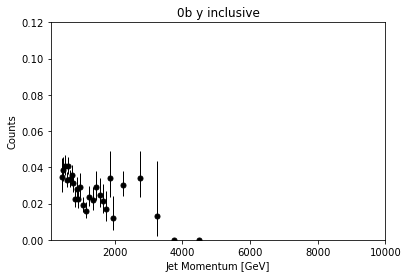

In [13]:
btag = '0b'

Num_cen = JetHT_unweighted['numerator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')
Denom_cen = JetHT_unweighted['denominator'].integrate('anacat', 'at'+btag+'cen').integrate('dataset', 'JetHT')
#mistag_cen = hist.plotratio(num = Num_cen, denom = Denom_cen,
#                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
#                                unc = 'num')

Num_fwd = JetHT_unweighted['numerator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')
Denom_fwd = JetHT_unweighted['denominator'].integrate('anacat', 'at'+btag+'fwd').integrate('dataset', 'JetHT')
#mistag_fwd = hist.plotratio(num = Num_fwd, denom = Denom_fwd,
#                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
#                                unc = 'num')

Num_inc = Num_cen.add(Num_fwd)
Denom_inc = Denom_cen.add(Denom_fwd)
mistag_inclusive = hist.plotratio(num = Num_inc, denom = Denom_inc,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
plt.title(btag+' y inclusive')
plt.ylim(bottom = 0, top = 0.12)
plt.xlim(left = 100, right = 10000)
#mistag_inclusive.set_xscale('log')

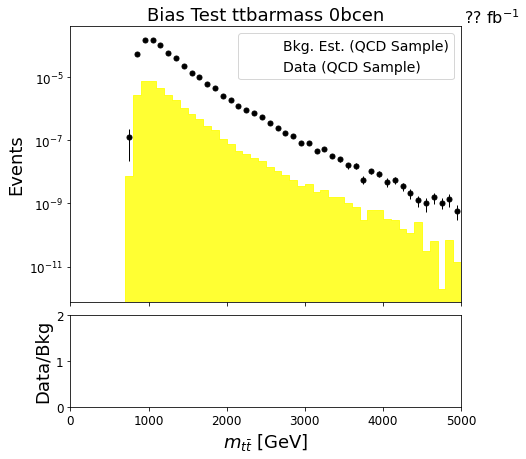

In [14]:
""" ---------- Comparing Background Estimate to Unweighted MC (TEST WITHOUT DATA/ BIAS TEST) ---------- """
 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

#---- Define Histograms ----# 
MC_hist_wgt = QCD_weighted['ttbarmass'].integrate('anacat', 'at0bcen').integrate('dataset', 'QCD')
MC_hist_unwgt = QCD_unweighted['ttbarmass'].integrate('anacat', 'at0bcen').integrate('dataset', 'QCD')

hist.plot1d(MC_hist_wgt, ax=ax, clear=True,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
hist.plot1d(MC_hist_unwgt, ax=ax, clear=False,
                    error_opts=data_err_opts)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title('Bias Test ttbarmass 0bcen')
leg = ax.legend(labels=["Bkg. Est. (QCD Sample)", "Data (QCD Sample)"])

#---- Plot Ratio ----#
hist.plotratio(num = MC_hist_unwgt, denom = MC_hist_wgt, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
Lint = str(Lum*.001) # Integrated Luminosity
lumi = plt.text(1.15, 1.07, "?? fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )

In [15]:
lut_file = maindirectory + '/LookupTables/mistag_QCD_at0bcen.csv'
df = pd.read_csv(lut_file)
mtr = df['M(p)'].values
MMR = mtr.sum()/mtr.size
print('Mean Mistag Rate (MMR) = ', MMR)
print()

nevts = QCD_unweighted['cutflow']['at0bcen']
bkg_nevts = QCD_weighted['cutflow']['at0bcen']

print('Number of Data =       ', nevts)
print('Number of Background = ', bkg_nevts)

Mean Mistag Rate (MMR) =  0.03530711660165365

Number of Data =        8473
Number of Background =  8473


Mean Mistag Rate (MMR) =  0.02683955183882789
Number of Data =        10326
Number of Background =  10326



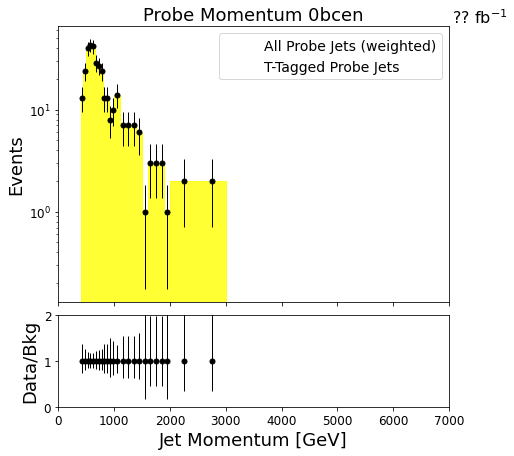

In [16]:
""" ---------- Comparing Background Estimate to Unweighted MC (TEST WITHOUT DATA/ CLOSURE TEST) ---------- """
SaveDirectory = maindirectory + '/' + 'ClosureTests' + '/' # split histograms into subdirectories
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already

#---- Histogram Window Config. ----# 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

#---- Useful Information ----# 
b_y = '0bcen' # b-tag category and rapidity window
lut_file = maindirectory + '/LookupTables/mistag_JetHT_at' + b_y + '.csv'
df = pd.read_csv(lut_file)
p_vals = df['p']
mtr = df['M(p)'].values
MMR = mtr.sum()/mtr.size
print('Mean Mistag Rate (MMR) = ', MMR)
#print(p_vals)
#print(mtr)

nevts = JetHT_unweighted['cutflow']['at0bcen']
bkg_nevts = JetHT_weighted['cutflow']['at0bcen']

print('Number of Data =       ', nevts)
print('Number of Background = ', bkg_nevts)
print()

#---- Define Histograms ----# 
hist_wgt_anacat = 'at' + b_y
hist_unwgt_anacat = 'At' + b_y
hist_unwgt_pretag_anacat = 'at' + b_y

MC_hist_wgt = JetHT_weighted['probep'].integrate('anacat', hist_wgt_anacat).integrate('dataset', 'JetHT')
MC_hist_unwgt = JetHT_unweighted['probep'].integrate('anacat', hist_unwgt_anacat).integrate('dataset', 'JetHT')
MC_hist_unwgt_pretag = JetHT_unweighted['probep'].integrate('anacat', hist_unwgt_pretag_anacat).integrate('dataset', 'JetHT')

hist.plot1d(MC_hist_wgt, ax=ax, clear=True,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
hist.plot1d(MC_hist_unwgt, ax=ax, clear=False,
                    error_opts=data_err_opts)

d = {'p': p_vals, 'M(p)': mtr, 
     'unwgt at0bcen MC': MC_hist_unwgt_pretag.values()[()], 
     'wgt at0bcen MC': MC_hist_wgt.values()[()], 
     'At0bcen MC': MC_hist_unwgt.values()[()]}
#df1 = pd.DataFrame(data=d)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#    print(df1)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title('Probe Momentum ' + b_y)
leg = ax.legend(labels=["All Probe Jets (weighted)", "T-Tagged Probe Jets"])

#---- Plot Ratio ----#
hist.plotratio(num = MC_hist_unwgt, denom = MC_hist_wgt, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
Lint = str(Lum*.001) # Integrated Luminosity
lumi = plt.text(1.15, 1.07, "?? fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )
#filename = 'ClosureTest_' + b_y + '.png'
#plt.savefig(SaveDirectory+filename, bbox_inches="tight")
#print(filename + ' saved')

In [17]:
nevts = QCD_unweighted['cutflow']['At0bcen']
bkg_nevts = QCD_weighted['cutflow']['at0bcen']

print('Number of Data =       ', nevts)
print('Number of Background = ', bkg_nevts)

Number of Data =        362
Number of Background =  8473


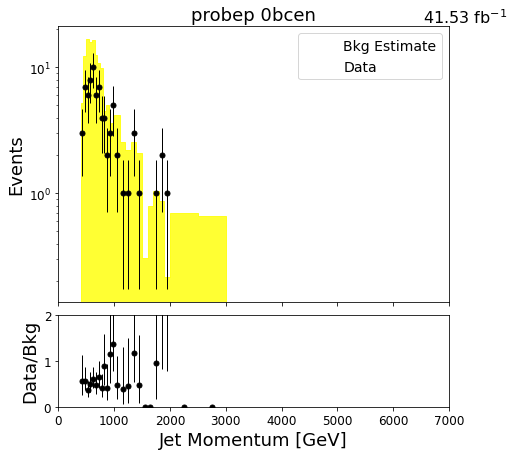

In [18]:
""" ---------- Comparing Background Estimate to Unweighted Data (Checks One Histogram) ---------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag --------------- """
""" --------------- Data: Unweighted Data from the Signal Region (2t tag region) -------------- """
 
plt.rcParams.update({
'font.size': 14,
'axes.titlesize': 18,
'axes.labelsize': 18,
'xtick.labelsize': 12,
'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
)
fig.subplots_adjust(hspace=.07)

#---- Name of Histogram to plot ----#
name = 'probep'

#---- Define Histograms ----# 
Data_hist_wgt_1 = JetHT_weighted[name].integrate('anacat', '1t0bcen').integrate('dataset', 'JetHT')
Data_hist_wgt_2 = JetHT_weighted[name].integrate('anacat', '2t0bcen').integrate('dataset', 'JetHT')
Data_hist_unwgt = JetHT_unweighted[name].integrate('anacat', '2t0bcen').integrate('dataset', 'JetHT')
Data_hist_preunwgt = JetHT_unweighted[name].integrate('anacat', '1t0bcen').integrate('dataset', 'JetHT')

#print("Only 1t weighted region = \n", Data_hist_wgt_1.values())
#print("Only 1t pre-weighted region = \n", Data_hist_preunwgt.values())
#print("2t weighted region = \n", Data_hist_wgt_2.values())
#print("2t unweighted region (Signal) = \n", Data_hist_unwgt.values())

Background = Data_hist_wgt_1.add(Data_hist_wgt_2)
Signal = Data_hist_unwgt

hist.plot1d(Background, ax=ax, clear=True,
                    fill_opts=stack_background_opts, error_opts=stack_error_opts)
hist.plot1d(Signal, ax=ax, clear=False,
                    error_opts=data_err_opts)

ax.set_yscale('log')
ax.autoscale('y')
ax.autoscale('x')#, tight=True) # doesn't look like its working...
ax.set_ylabel('Events')
ax.set_xlabel(None)
ax.set_title(name + ' 0bcen')
leg = ax.legend(labels=["Bkg Estimate", "Data"])

#---- Plot Ratio ----#
hist.plotratio(num = Signal, denom = Background, ax = rax,
               error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
               unc = 'num')
rax.set_ylabel('Data/Bkg')
rax.set_ylim(0,2)

#---- Labeling ----#
Lint = str(Lum*.001) # Integrated Luminosity
lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
        fontsize=16,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes
       )

In [19]:
lut_file = maindirectory + '/LookupTables/mistag_JetHT_at0bcen.csv'
df = pd.read_csv(lut_file)
mtr = df['M(p)'].values
MMR = mtr.sum()/mtr.size
print('Mean Mistag Rate (MMR) = ', MMR)
print()

nevts = JetHT_unweighted['cutflow']['2t0bcen']
bkg_nevts = JetHT_weighted['cutflow']['1t0bcen']
D_B = float(nevts/bkg_nevts)
print('Number of Data =       ', nevts)
print('Number of Background = ', bkg_nevts)
print('Data/Bkg. =            ', D_B)

Mean Mistag Rate (MMR) =  0.02683955183882789

Number of Data =        77
Number of Background =  3886
Data/Bkg. =             0.019814719505918683


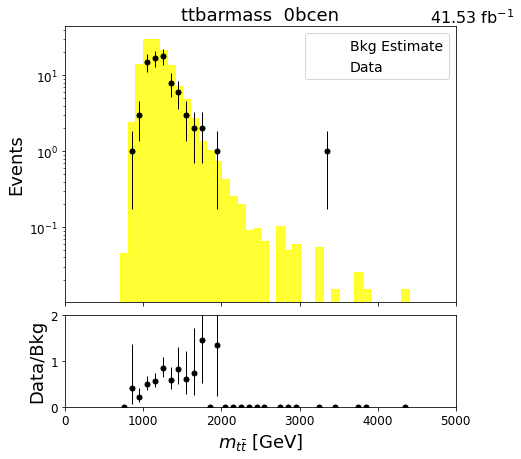

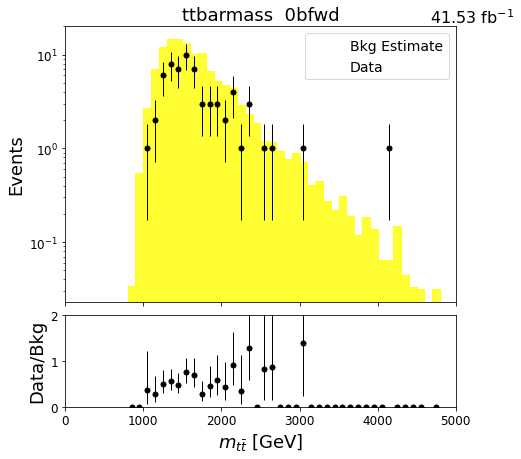

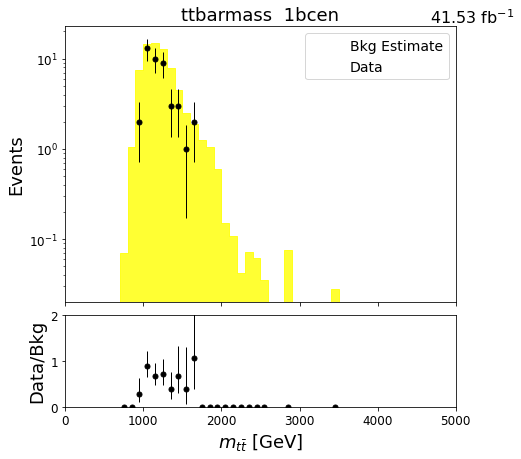

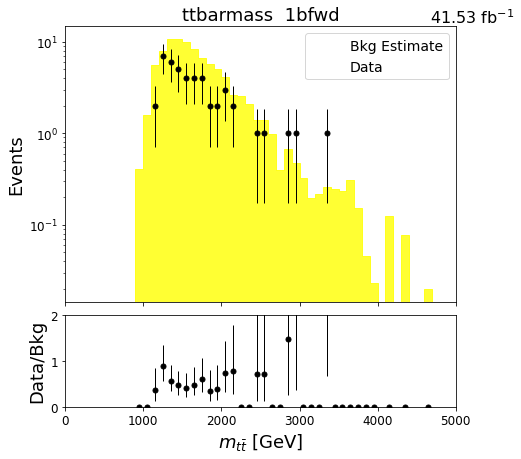

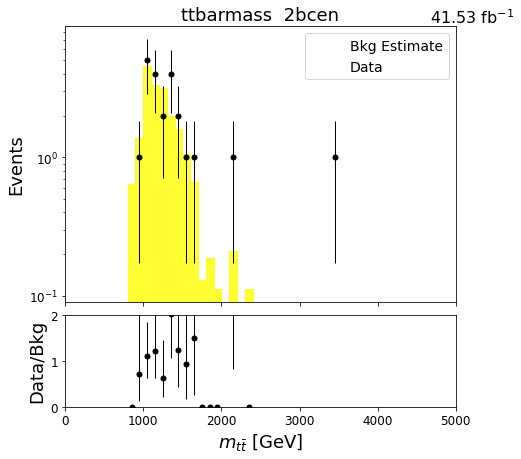

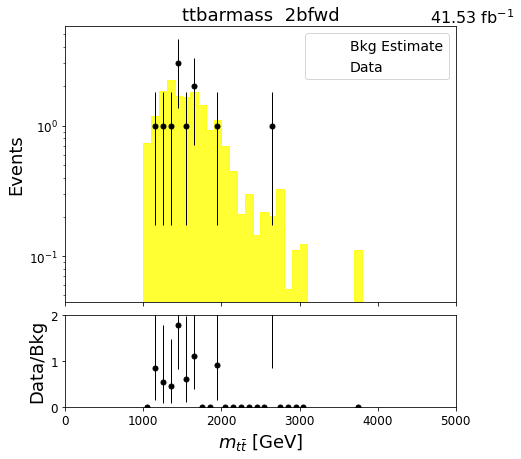

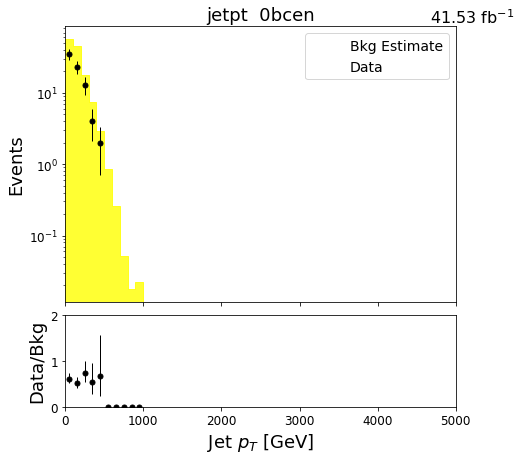

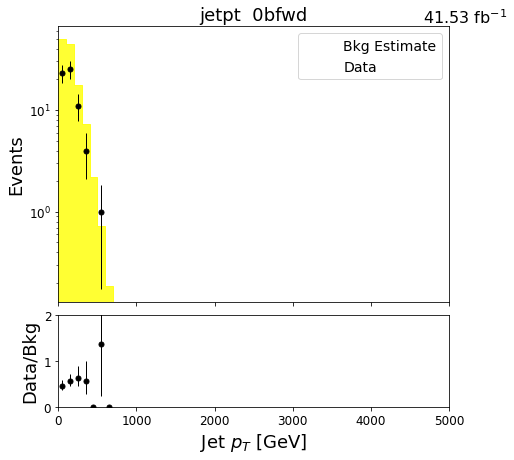

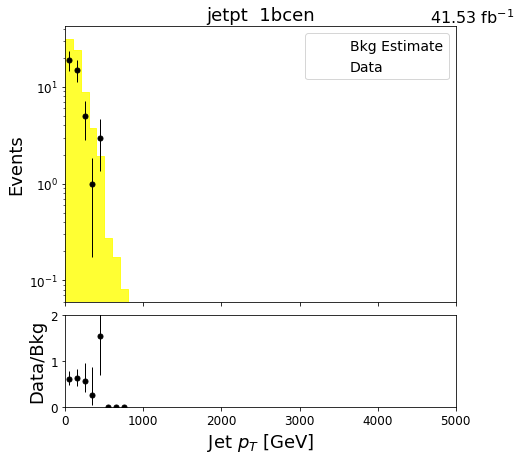

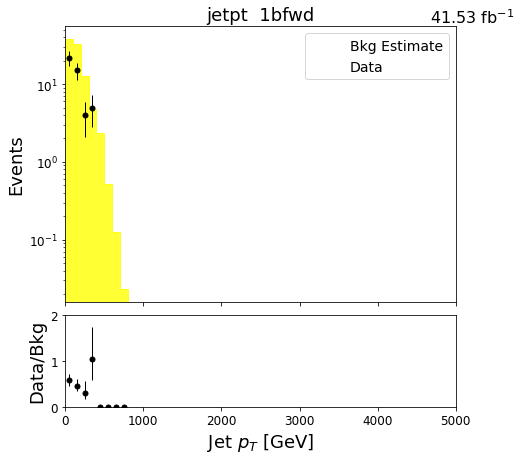

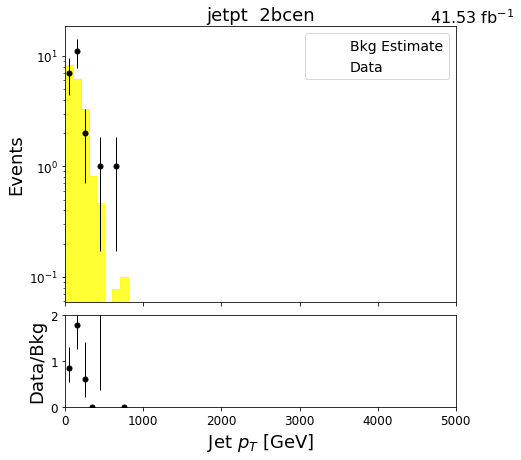

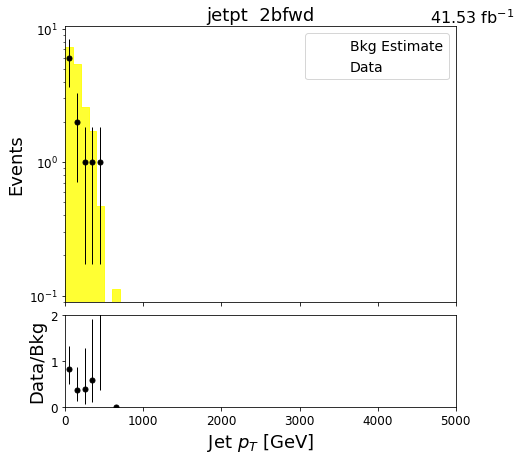

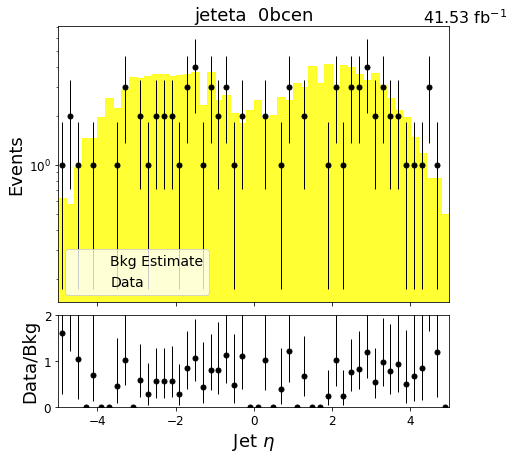

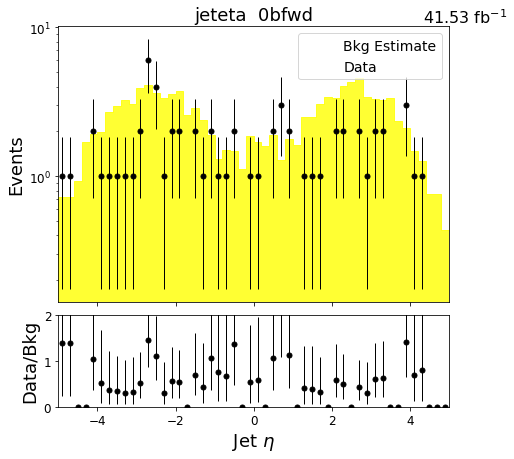

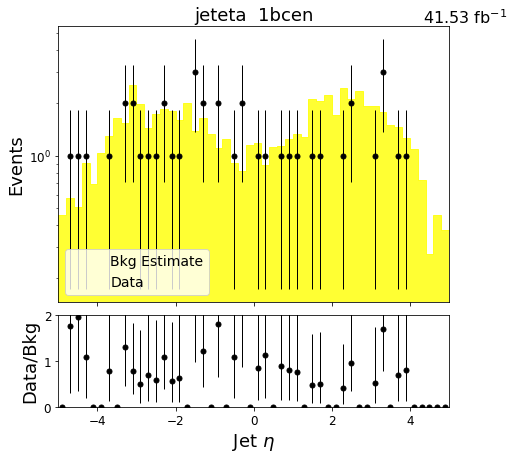

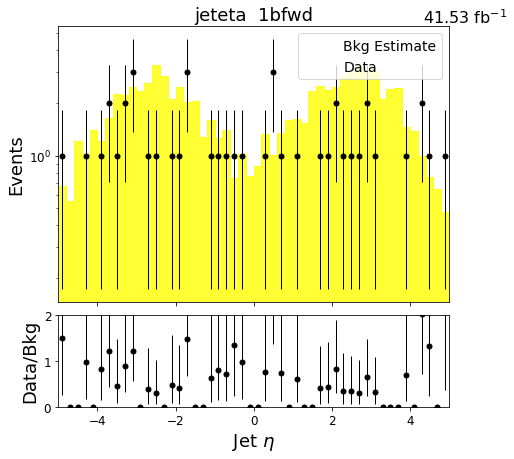

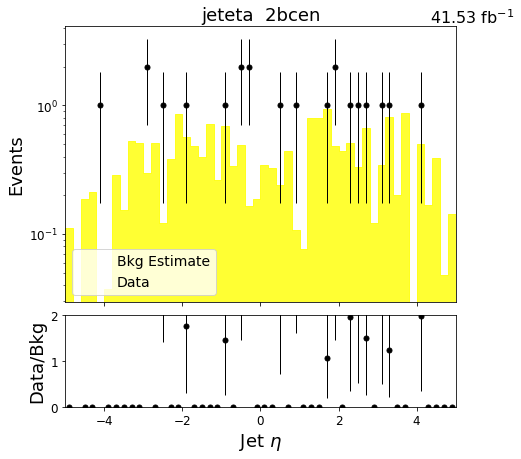

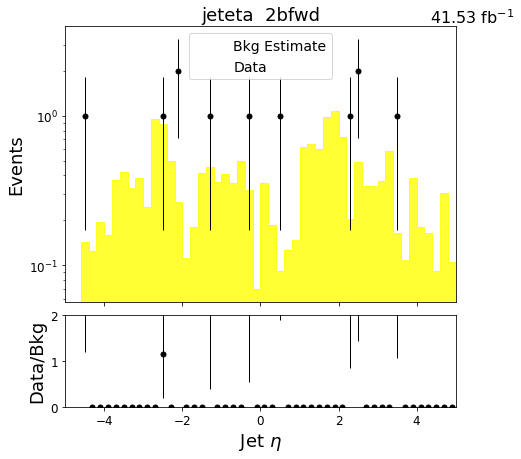

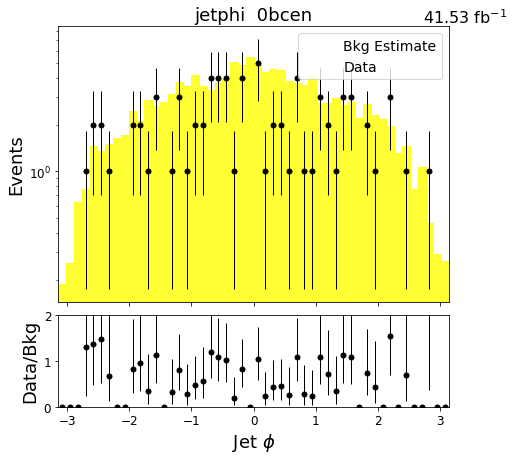

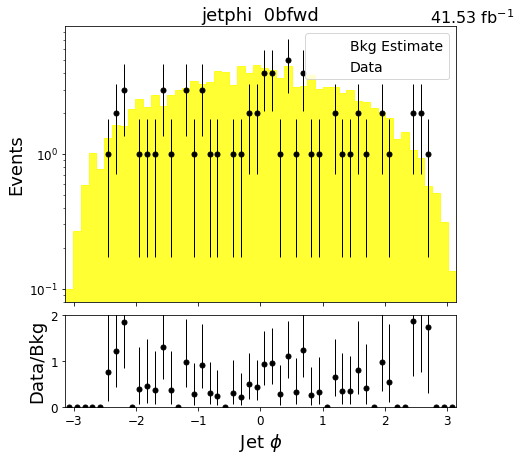

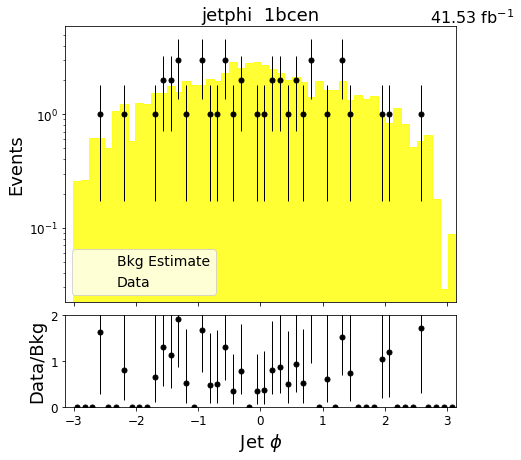

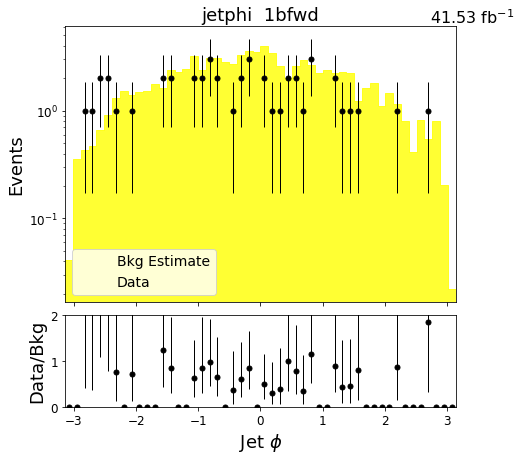

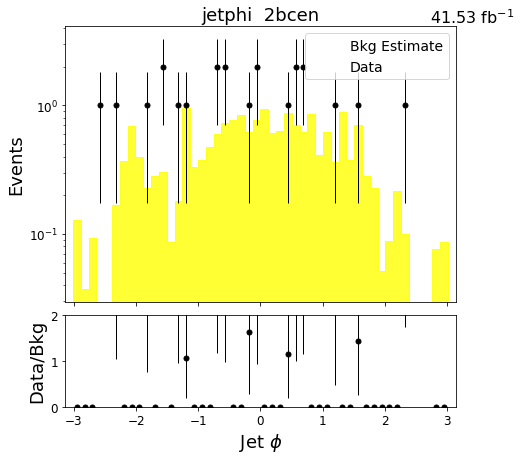

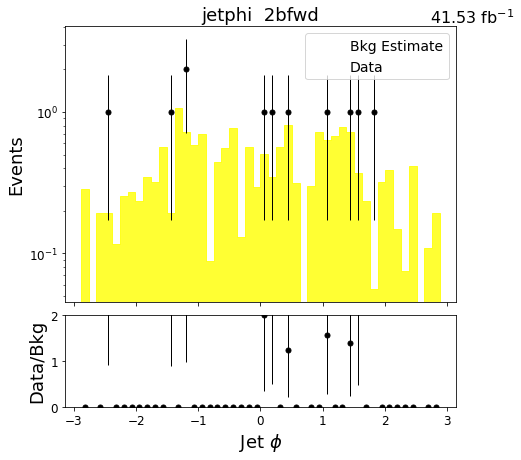

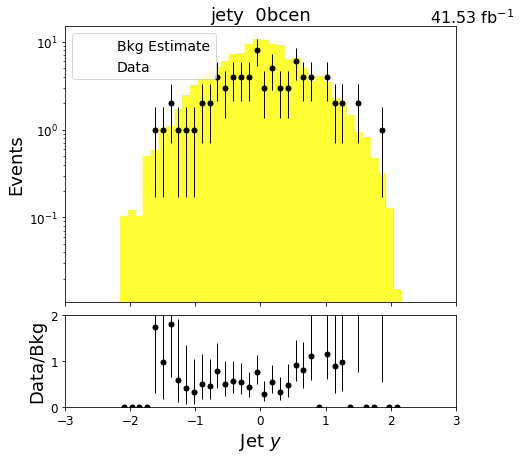

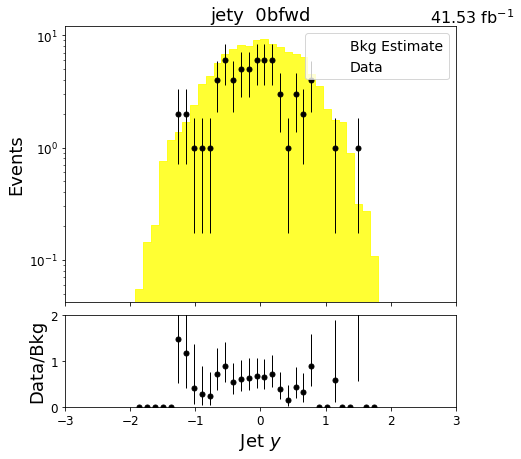

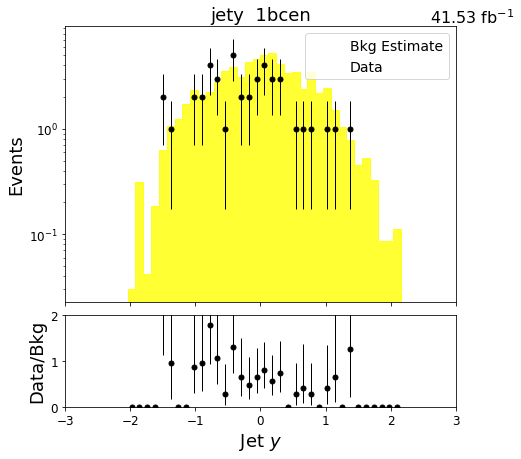

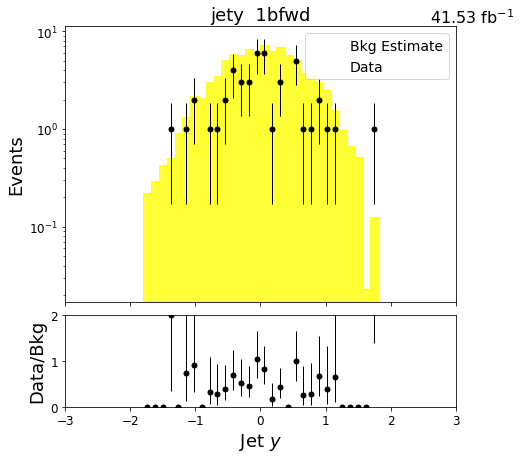

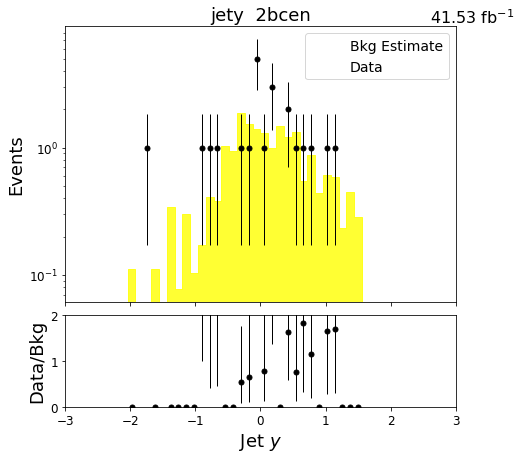

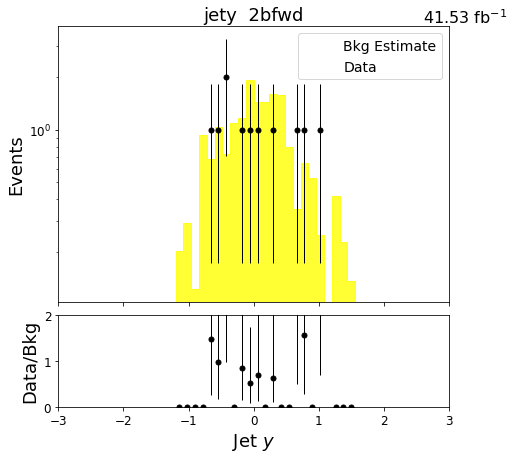

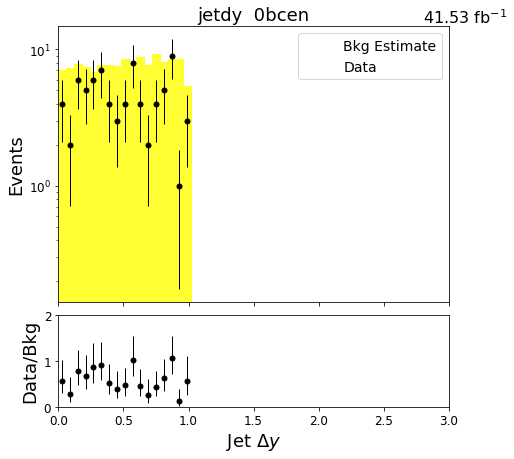

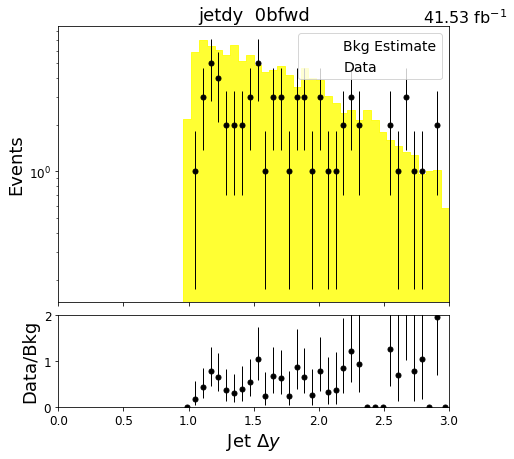

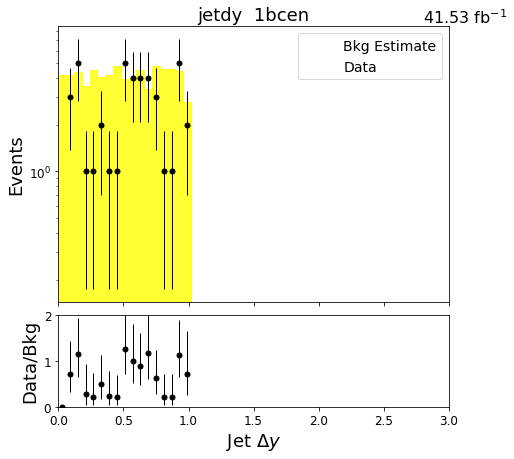

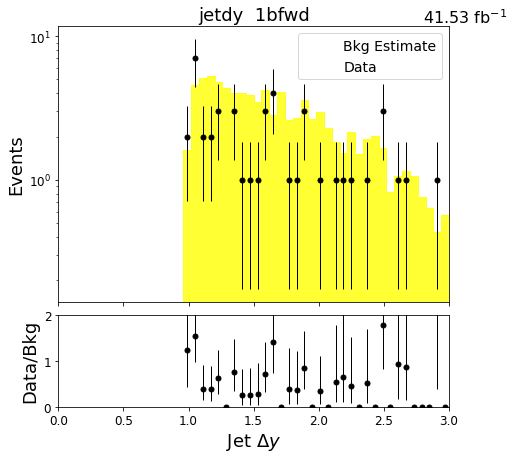

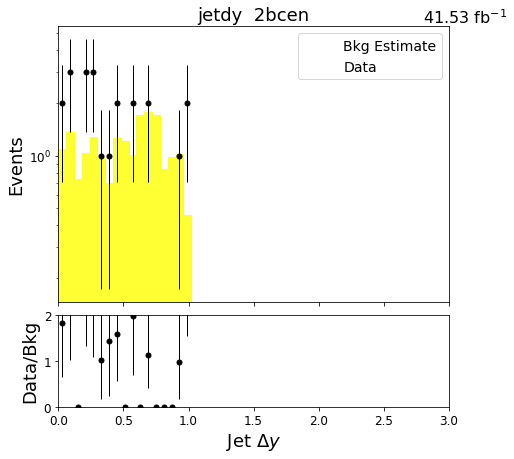

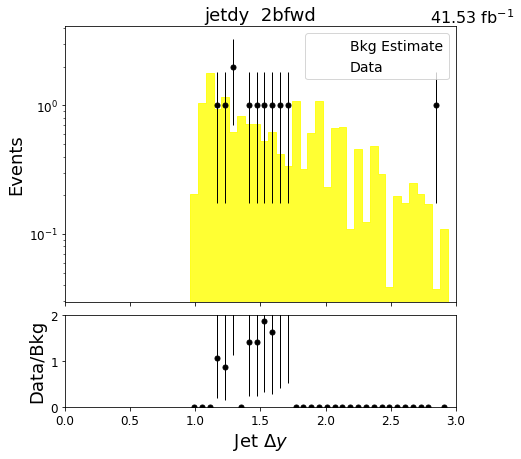

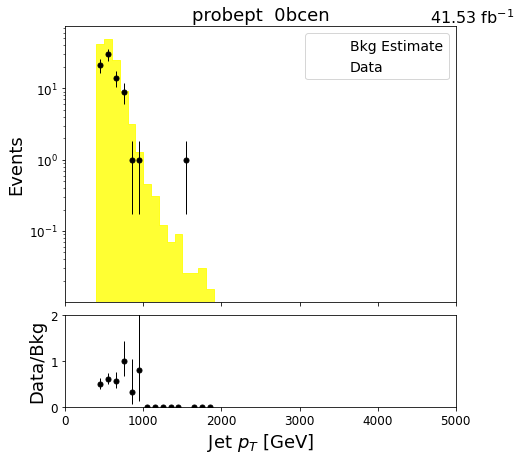

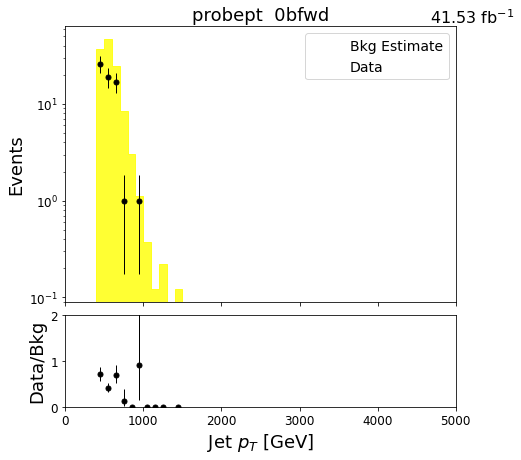

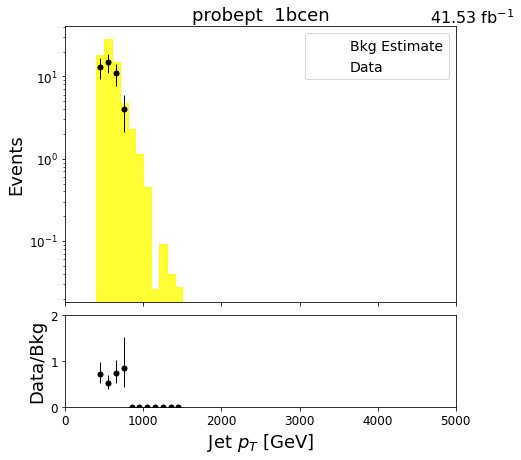

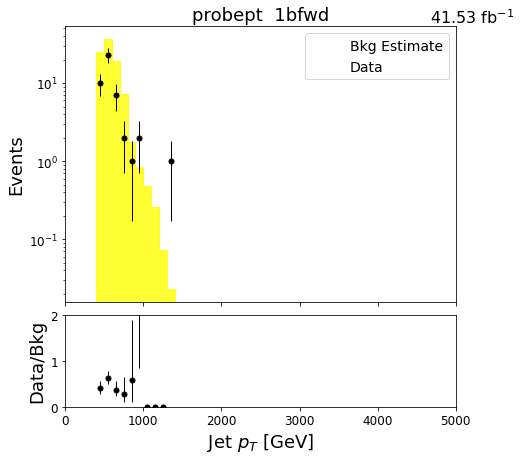

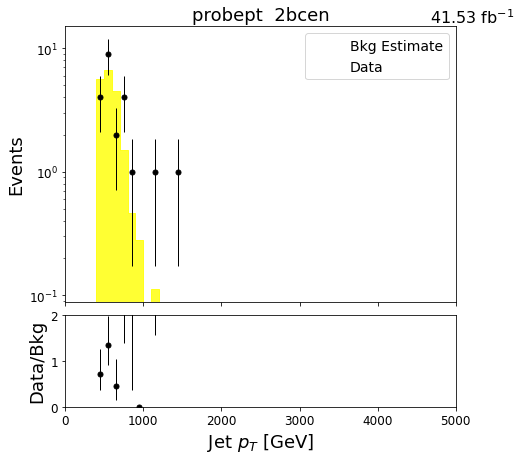

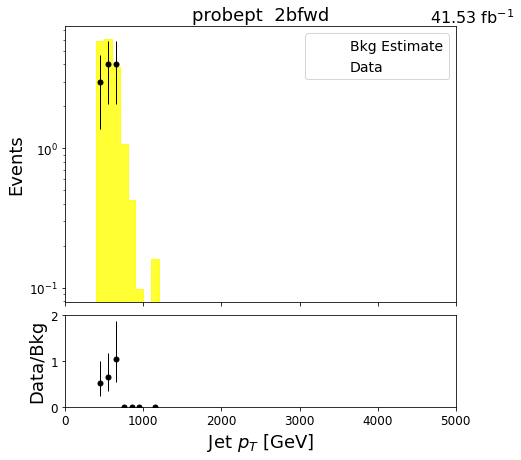

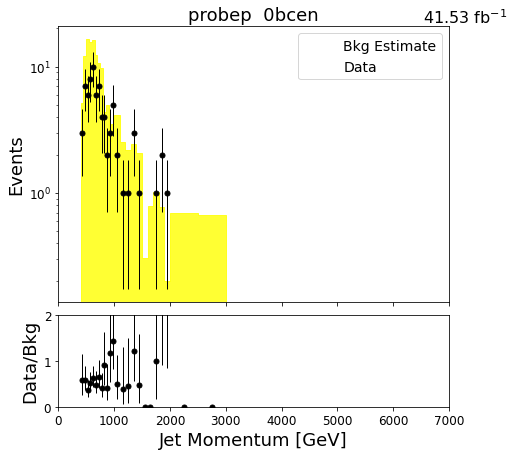

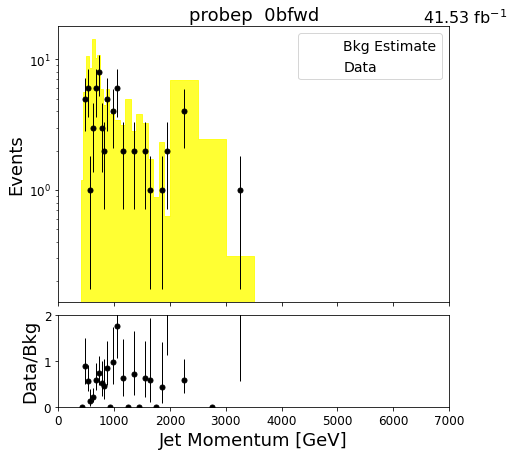

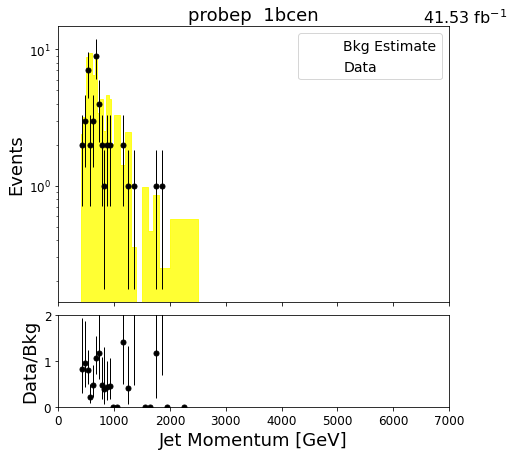

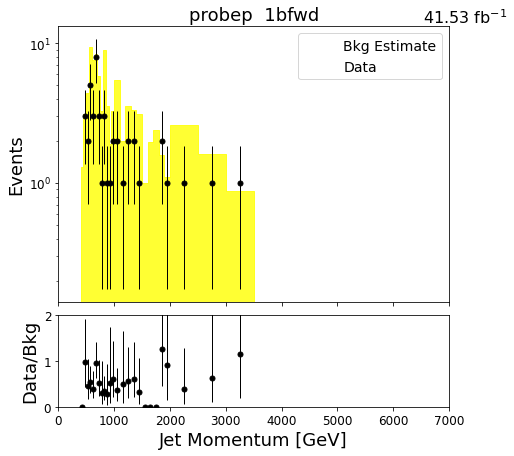

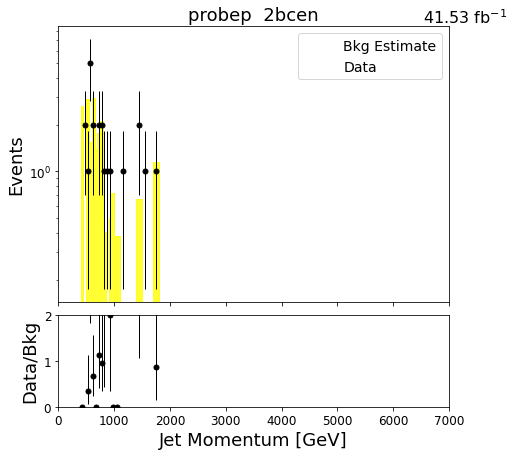

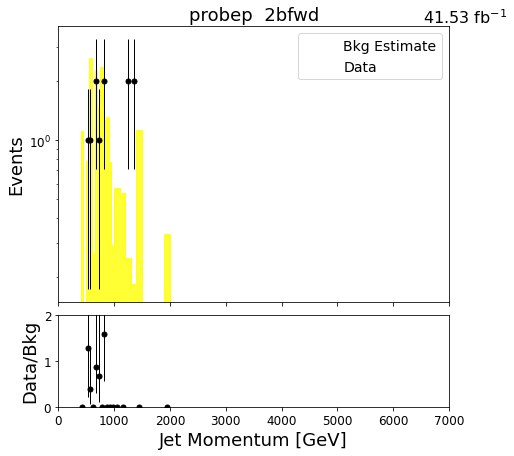

In [20]:
""" --------------- Background Estimates ---------- """
""" --------------- Background: t tagged probe jet from data weighted by mistag --------------- """
""" --------------- Data: Unweighted Data from the Signal Region (2t tag region) -------------- """
bcats = [
    '0bcen', '0bfwd',
    '1bcen', '1bfwd',
    '2bcen', '2bfwd'
] # Defined only for making all background estimate plots.

for ihist in list_of_hists:
    SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
    DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat in bcats: 
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(7,7),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)
        
        # ---- Needed Strings ---- #
        title = ihist + '  ' + icat
        filename = ihist + '_' + icat + '_BkgEst.' + 'png'
        bkg_cat = '1t' + icat
        signal_cat = '2t' + icat
        
        #---- Define Histograms ----# 
        Data_hist_wgt = JetHT_weighted[ihist].integrate('anacat', bkg_cat).integrate('dataset', 'JetHT')
        Data_hist_unwgt = JetHT_unweighted[ihist].integrate('anacat', signal_cat).integrate('dataset', 'JetHT')

        hist.plot1d(Data_hist_wgt, ax=ax, clear=True,
                            fill_opts=stack_background_opts, error_opts=stack_error_opts)
        hist.plot1d(Data_hist_unwgt, ax=ax, clear=False,
                            error_opts=data_err_opts)

        ax.set_yscale('log')
        ax.autoscale('y')
        ax.autoscale('x')#, tight=True) # doesn't look like its working...
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(title)
        leg = ax.legend(labels=["Bkg Estimate", "Data"])

        #---- Plot Ratio ----#
        hist.plotratio(num = Data_hist_unwgt, denom = Data_hist_wgt, ax = rax,
                       error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                       unc = 'num')
        rax.set_ylabel('Data/Bkg')
        rax.set_ylim(0,2)

        #---- Labeling ----#
        Lint = str(Lum*.001) # Integrated Luminosity
        lumi = plt.text(1.15, 1.07, Lint[:6] + " fb$^{-1}$",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes
               )
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')